<a href="https://colab.research.google.com/github/stefanbringuier/randomonium/blob/main/notebooks/BayesianOptimization_Ch2_JuliaVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Julia Implementation of Ch.2 example from "Bayesian Optimization for Materials Science" D. Packwood
**Author** Stefan Bringuier

Book link: https://link.springer.com/book/10.1007/978-981-10-6781-5

Original R code: https://drive.google.com/file/d/1IRNYSH__DzQnlVe7vez_eG4RPuCWUA5G/view


## Julia Setup
---
**Once Julia is installed you need to reload the page, CTRL+R**



In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.9.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia StatsBase Distributions DataFrames CSV Plots Optim"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.9.2 on the current Colab Runtime...
2023-07-19 17:34:21 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.9/julia-1.9.2-linux-x86_64.tar.gz [146384758/146384758] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package StatsBase...
Installing Julia package Distributions...
Installing Julia package DataFrames...
Installing Julia package CSV...
Installing Julia package Plots...
Installing Julia package Optim...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.9

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


## Packages

In [24]:
using Downloads
using DataFrames
using CSV
using StatsBase, Distributions
using Plots
using Optim
using LinearAlgebra
gr();

## Bayesian Optimization Steps

### Kernel and Gaussian Process

In [25]:
function SquareKernel(r1::Float64,r2::Float64,alpha::Float64,beta::Float64)
    square_dist = (r1-r2)^2;
    K12 = alpha*exp(-1.00e0*beta*square_dist);
    return K12
end

function SquareKernel(r1::Array{Float64},r2::Array{Float64},alpha::Float64,beta::Float64)
    square_dist = (r1-r2)*transpose(r1-r2);
    K = alpha.*exp.(-1.00e0*beta.*square_dist);
    return K
end

function MeanPrior(x::Array{Float64,1})
    n = length(x);
    μ = mean(x);
    # nx1 vector filled with mean value of samples
    μ_vec = fill(μ,(n));
    return (μ,μ_vec)
end

function CovarianceMatrix(x::Array{Float64,1},alpha::Float64,beta::Float64)
    k = size(x)[1];
    Σ = zeros(k,k); #This is the covariance of the sample points i-k,i-k
    for i=1:k
        for j=1:k
        Σ[i,j] = SquareKernel(x[i],x[j],alpha,beta);
        end
    end
    return Σ
end

function SampleCovariance(s::Float64,x::Array{Float64,1},
    alpha::Float64,beta::Float64)
    k = size(x)[1];
    Σ_i = zeros(1,k); #Row vector
    for i=1:k
        Σ_i[i] = SquareKernel(s,x[i],alpha,beta)
    end
    return Σ_i
end;

### Aquisition Function & Posterior

In [26]:
function PosteriorDensity(K_i::Array{Float64,2},K_ii::Array{Float64,2},
        μi::Array{Float64,1},ui::Array{Float64,1})
    K_ii_inv = pinv(K_ii);
    μ = K_i*K_ii_inv*(μi-ui);
    σ = K_i*K_ii_inv*transpose(K_i);
    return (μ,σ)
end

function ExpectedImprovement(s::Array{Float64,1},μs::Array{Float64,1},σs::Array{Float64,1};min=true)
    normal = Normal(0.00e0,1.00e0);
    if min == true
        min_s = minimum(s);
        arg = min_s.-μs;
        normdev = (arg)./sqrt.(σs);
    else
        max_s = maximum(s);
        arg = μs.-max_s;
        normdev = (arg)./sqrt.(σs);
    end
    EI = arg.*cdf.(normal,normdev) + sqrt.(σs).*pdf.(normal,normdev);

    bestEIval,bestEIindx = findmax(EI);
    return (bestEIindx,bestEIval,EI)
end

function AddSample!(s::Array{Float64,1},x::Array{Float64,1},indx::Integer)
        append!(x,s[indx]);
end;

### (Optional) Maximize log likelihood of prior

In [27]:
#Optimize coefficients
function LogPrior(p::Array{Float64,1},x::Array{Float64,1})
        ns = length(x);
        b = 1.00e0/(2.00e0*p[2]*p[2]);
        Σ = CovarianceMatrix(x,p[1],b)
        #Why is this neccessary, its redundant
        #maybe for postive definite matrix?
        for k=1:ns-1
            for j=k+1:ns
                Σ[k,j] = SquareKernel(x[k],x[j],p[1],b);
                Σ[j,k] = Σ[k,j]
            end
        end
        Σ_inv = inv(Σ);

        mu_x,mu_xvec = MeanPrior(x);
        a = (1.00e0/ns)*transpose(x-mu_xvec)*Σ_inv*(x-mu_xvec);
        det_Σ = 0.50e0*log(abs(det(Σ)));
        logPM = -0.5e0*a - det_Σ;
        return -logPM
end

function MinObjFunc(x::Array{Float64};low1=0.001e0,low2=0.001e0)
    lower=[low1,low2];
    upper=[10.00,10.00];
    initial = [0.5e0,0.5e0];
    opt = NelderMead()
    bound_opt = Fminbox(opt)

    result= optimize(p->LogPrior(p,x),lower,upper,initial,bound_opt)
    return Optim.minimizer(result)
end;


### Bayes Opt of Black Box Function
Now create the initial data points sampled from the "black-box function". For simplicity remove any short distance or high energy points (I assume this impacts the sampling due to the variance). Get sample via random index. Then **compute** the covariance matrix of the sample data. Compute the posterior mean for all the positions rᵢ and the variance. Then return the results and plot against the known values to see how well the Bayesian prediction went.

In [40]:
function InitialDataSampler(data;num_samples=5,cutoff=1.75)
  filter_slice = data[!,1] .> cutoff;
  r_o = data[!,:r][filter_slice];
  E = data[!,:E][filter_slice];
  rand_index = sample(1:length(r_o),num_samples,replace=false);
  ro_s = r_o[rand_index];
  E_s = E[rand_index];
  return r_o,ro_s,E,E_s
end

function RunBO(data,acoeff,bcoeff;nruns=5)
  r_o,ro_s,E,E_s = InitialDataSampler(data)

  mu_E,mu_Evec = MeanPrior(E_s);
  μ_star = zeros(length(r_o));
  σ_star = zeros(length(r_o));

  a_indx,a_expimpval = [],[];

  for j=1:nruns
      Σ = CovarianceMatrix(ro_s,acoeff,bcoeff);
      mu_E,mu_Evec = MeanPrior(E_s);

      for i=1:length(r_o)
          σ_i = SampleCovariance(r_o[i],ro_s,acoeff,bcoeff);
          μ,σ = PosteriorDensity(σ_i,Σ,mu_Evec,E_s);
          μ_i = mu_E .- μ;
          σ_ii = SquareKernel(r_o[i],r_o[i],acoeff,bcoeff).-σ;
          if σ_ii[1] < 0.00
              σ_ii[1] = -1.00e0*σ_ii[1];
          end
          μ_star[i] = μ_i[1];
          σ_star[i] = σ_ii[1];
      end

      indx,expimpval,EI = ExpectedImprovement(r_o,μ_star,σ_star)
      push!(a_indx,j);
      push!(a_expimpval,EI);

      AddSample!(r_o,ro_s,indx);
      AddSample!(E,E_s,indx);
  end
  return  r_o,ro_s,E,E_s,μ_star,σ_star
end;

## Example: Br-Br interatomic potential

In [41]:
data_url="https://drive.google.com/uc?id=1pUyF-q6YbhrF559jpdaPlvusO4aOohyi&export=download"
save_path = "Br2_BO_data.csv"
Downloads.download(data_url, save_path)
data = CSV.read(save_path,DataFrame,missingstring="\\N");

Running Bayes Opt with EI for fixed kernel parameters.

In [50]:
acoeff=0.50e0;
L = 0.5e0;
bcoeff=1.00e0/(2.00e0*L*L);
# r_o: domain, ro_s: sampled points, E_s: observed value
r_o, ro_s, E, E_s, μ_star,σ_star = RunBO(data,acoeff,bcoeff);

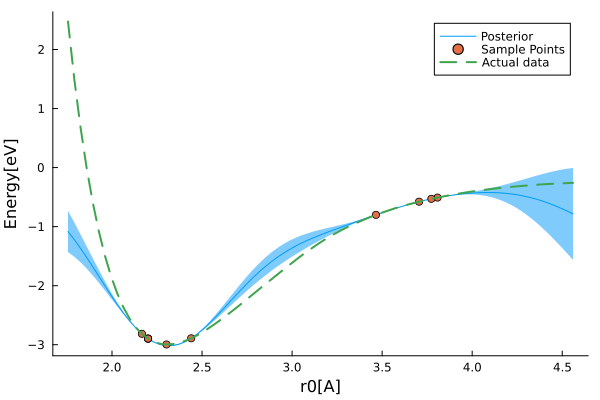

In [51]:
plot(r_o,μ_star,grid=false,ribbon=1.96*sqrt.(σ_star),
fillalpha=.5,xlabel="r0[A]",ylabel="Energy[eV]",label="Posterior")
plot!(ro_s,E_s,seriestype=:scatter,label="Sample Points")
plot!(r_o,E,line=(:dash,2),label="Actual data")

Now optimize kernel params using marginal likelihood maximization. Based on the plot it looks like overfitting, since the uncertainty is far to small.

In [48]:
# Finds optimal hyperparams, but overfits!
r_o,ro_s,E,E_s = InitialDataSampler(data)
acoeff, L  = MinObjFunc(E_s);
bcoeff=1.00e0/(2.00e0*L*L);
r_o, ro_s,E,E_s, μ_star,σ_star = RunBO(data,acoeff,bcoeff);

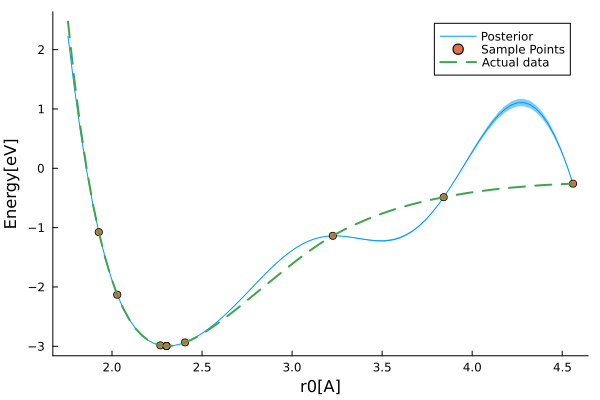

In [49]:
plot(r_o,μ_star,grid=false,ribbon=1.96*sqrt.(σ_star),
fillalpha=.5,xlabel="r0[A]",ylabel="Energy[eV]",label="Posterior")
plot!(ro_s,E_s,seriestype=:scatter,label="Sample Points")
plot!(r_o,E,line=(:dash,2),label="Actual data")